<a href="https://colab.research.google.com/github/b4wolf/linuxExercises/blob/main/TempoTutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tutorial 9: TEMPO and Remote Sensing

This tutorial will work with TEMPO data. In the previous tutorial, we looked at the entire area of the netCDF file. But, as scientists, we often have a specific region of interest that is a subset of the larger dataset region. In this tutorial, we'll learn how to select and plot only an area of interest to us.

By the end of this tutorial, you will be able to:
  - Understand the basics of remote sensing
  - Explore different ways of visualizing TEMPO data
  - Investigate influencing factors of calcuating TEMPO data

There will be two approaches, one will be through directly accesing the data from NASA, and the other will be using a tool called PyRsig.

Official documentation is still being created at this time, so further refinement of this tutorial is necessary.

This tutorial will utilize level two data, as level three data is not yet released.

Level 2 data are Geophysical parameter data.  TEMPO level 2 data is separated into sections called granules. Level 3 is processed Earth-gridded geophysical  data, which have undergone averaging or gridding.


As a way to start investigating TEMPO data without any programming experience, this tutorial of Panoply is very helpful:
https://coastwatch.gitbook.io/satellite-course/tutorials/netcdf-and-panoply-tutorial

Currently, data is in early access mode from NASA. This means that this tutorial will need to be updated once the data pipeline is fully published. We will be using methods you've learned in previous tutorials to access the data remotely.

### Special thanks to Dr. Monica Harkey and Summer Acker

These installations below (of netCDF4, cftime, and cartopy) are because google colab does not support their installation, and each time your colab spinup is shut down, the install must be redone.

In [57]:
!pip install netCDF4
!pip install cftime
!pip install cartopy
!pip install earthaccess
!pip install qq
!pip install pyrsig
!pip install pycno
!pip install pyproj

  Preparing metadata (setup.py) ... done
  Created wheel for qq: filename=qq-1.0.0-py3-none-any.whl size=1145 sha256=9eed1cb3907d8f1ef545f769a7bddb8495d174ebb0bf294c99c57b8df319a753
  Stored in directory: /root/.cache/pip/wheels/47/64/9e/7da27de797243943ec31d30451389881d7f3b66ff000c59e1f
Successfully built qq
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 197.8/197.8 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 3.6 MB/s eta 0:00:00


In [58]:
# For plotting and visualizing data
import matplotlib.pyplot as plt
from matplotlib.ticker import FixedLocator
import matplotlib.ticker as ticker
# For accessing the EPA data pipeline tool
import pyrsig
# For map overlay software to read CNO and CNOB files
import pycno
# For reading and writing NetCDF files (array-oriented scientific data)
import netCDF4
# For numerical computations with arrays and matrices
import numpy as np
# For data analysis and manipulation (DataFrame and Series)
import pandas as pd
# For handling non-standard calendars and date-times (NetCDF compatibility)
import cftime
# For time-related functions (current time, execution time, timestamps)
import time
# For interacting with the operating system (file and directory management)
import os
# For manipulating dates and times
import datetime
# For finding pathnames matching a specified pattern (file manipulation)
import glob
# For displaying rich output in Jupyter notebooks
from IPython.display import display, clear_output
# For color specifications and conversions in matplotlib
import matplotlib.colors as mcolors
# For working with labeled multi-dimensional arrays (NetCDF data handling)
import xarray as xr
# For cartographic projections and coordinate systems (map creation)
import cartopy.crs as ccrs
# For common drawing elements like coastlines and borders on maps
import cartopy.feature as cfeature
# For downloading data from urls
import requests
# for opening zip files
from zipfile import ZipFile
# For dealing with NetCDF
from netCDF4 import Dataset
# for pathing
from pathlib import Path
from PIL import Image
# for accessing NASA
import earthaccess

**Knowledge check:** What does it mean to mount the notebook, and is that necessary locally?

# TEMPO summary

TEMPO, or Tropospheric Emissions: Monitoring of Pollution, is an important and newly launched geostationary sattelite to monitor air pollution consistently over the United States during the day.

There are many physical phenomona involved in accurately measuring the constituents of the vertical column. This tutorial will review
Certainly! Here are the complete definitions:

- **Viewing angle**: The angle at which a sensor or instrument observes the Earth's surface. The viewing angle affects the path length through the atmosphere, which can influence the measurements of atmospheric constituents due to varying atmospheric thickness.

- **Optical path**: The path that light or radiation travels through the atmosphere. The optical path length can be longer or shorter depending on the viewing angle and the presence of atmospheric constituents, impacting the amount of absorption and scattering that occurs.

- **Albedo**: The reflectivity of the Earth's surface. Albedo is the fraction of incident sunlight that is reflected by the surface, and it can vary significantly depending on surface type (e.g., snow, water, vegetation). High albedo surfaces reflect more sunlight, which can affect the measurements of atmospheric constituents by changing the amount of light available for scattering and absorption.

- **Air mass factors**: A scaling factor that accounts for the varying path lengths that light travels through the atmosphere. Air mass factors are used to convert satellite or remote sensing measurements into concentrations of atmospheric constituents by correcting for the effects of viewing angle and optical path length.

- **Cloud cover**: The fraction of the sky covered by clouds. Cloud cover can significantly impact measurements of atmospheric constituents by obscuring the surface and lower atmosphere, scattering and absorbing light, and introducing additional variability in the optical path. Accurate measurements often require cloud-free conditions or cloud correction algorithms.

# Mounting to drive

This notebook is designed to be run either locally or through google colab. If you choose to use this on colab, you will need to mount the notebook to your drive (using your enterprise email is easiest). If you choose to run this locally, then the following will be done using relative paths to your working directory.

# Accessing the data

TEMPO filenames have this format: “TEMPO_{PPP(P)}_L1_V01_{YYYY}{MM}{DD}T{HH}{NN}{SS}Z.nc”, where YYYY = (year), MM = (month), DD = (day), HH = (hour), NN =(minute), and SS = (second). This is the GMT time stamp that is the start of the time covered by the file. PPP(P) is the product type, which has the options of DRK for dark exposure, IRR for solar irradiance with the working diffuser,
and IRRR for solar irradiance with the reference diffuser. Similarly, the TEMPO radiance filenames are formatted “TEMPO_RAD_L1_V01_{YYYY}{MM}{DD}T{HH}{NN}{SS}Z_S{XXX}G{YY}.nc”, with XXX denoting the scan number and YY being the granule number.

The main variables are included in the product group.
For NO2, these are:
- vertical_column_total
- vertical_column_total_uncertainty
- vertical_column_troposphere
- vertical_column_troposphere_uncertainty
- vertical_column_stratosphere
- main_data_quality_flag

For HCHO, these are:
- vertical_column
- vertical_column_uncertainty
- main_data_quality_flag

The data is stored in netCDF files. Let's query the server to download some data to look at below, knowing the format of the files.

In [20]:
# Make new directories on the Google Colab instance for data files & map plots
Path('/content/data_files').mkdir(exist_ok=True)
Path('/content/map_plots').mkdir(exist_ok=True)

# Name paths to directories
data_path = Path('/content/data_files')
maps_path = Path('/content/map_plots')

# Earth Data
Special thanks to Dr. Amy Huff, IMSG at NOAA/NESDIS/STAR (amy.huff@noaa.gov) for the explanation of NASA Earthdata below:

NASA Earthdata is where TEMPO data lives, and we can connect to [NASA Earthdata Login](https://urs.earthdata.nasa.gov/) using the `earthaccess` python package. In this tutorial, we are using the `strategy='interactive'` option so you can manually enter your username and password for your Earthdata Login. You still have to set up an account with Earthdata before using this package. Register [here](https://urs.earthdata.nasa.gov/users/new) (it's free!).

Functions that might come in handy for this tutorial:
- [earthaccess.login()](https://earthaccess.readthedocs.io/en/stable/user-reference/api/api/#earthaccess.api.login): authenticates with Earthdata Login credentials
- [earthaccess.search_data()](https://earthaccess.readthedocs.io/en/stable/user-reference/api/api/#earthaccess.api.search_data): queries for dataset granules on NASA Earthdata
- [DataGranule.data_links()](https://earthaccess.readthedocs.io/en/stable/user-reference/granules/granules/#earthaccess.results.DataGranule.data_links): returns the URL link to a granule file
- [earthaccess.download()](https://earthaccess.readthedocs.io/en/stable/user-reference/api/api/#earthaccess.api.download): downloads granules files to local directory

In [12]:
auth = earthaccess.login(strategy='interactive')

Enter your Earthdata Login username: beewolf
Enter your Earthdata password: ··········


#####**Search for TEMPO NO2 Level 2 granules files**

The `earthaccess.search_data()` function has arguments that can be used to search for specific granules, including (but not limited to): `short_name`, `doi`, `temporal`, and `bounding_box`.

The Earthdata query parameters for TEMPO L2 NO2 granules, including  `short_name`, `doi`, and `version`, can be found in the View Collection Details tab of the [Earthdata Search page](https://search.earthdata.nasa.gov/search/granules/collection-details?p=C2724057189-LARC_CLOUD&pg[0][v]=f&pg[0][gsk]=-start_date&fi=TEMPO&fl=2%2B-%2BGeophys.%2BVariables%252C%2BSensor%2BCoordinates&as[instrument][0]=TEMPO&tl=1714155323.519!3!!).

In [13]:
# Input variables
year = input("Enter the year (YYYY): ")
month = input("Enter the month (MM): ")
day = input("Enter the day (DD): ")

# Define start and end times
start_time = '18:33:00'
end_time = '19:34:00'

# Construct observation start and end
observation_start = f'{year}-{month}-{day} {start_time}'
observation_end = f'{year}-{month}-{day} {end_time}'

# NASA Earthdata search parameters
short_name = 'TEMPO_NO2_L2'

# Search NASA Earthdata for TEMPO NO2 granules files
files_found = earthaccess.search_data(short_name=short_name, temporal=(observation_start, observation_end))
print(files_found)


Enter the year (YYYY): 2023
Enter the month (MM): 08
Enter the day (DD): 22
Granules found: 10
[Collection: {'ShortName': 'TEMPO_NO2_L2', 'Version': 'V01'}
Spatial coverage: {'HorizontalSpatialDomain': {'Geometry': {'GPolygons': [{'Boundary': {'Points': [{'Latitude': 60.242454529, 'Longitude': -41.026229858}, {'Latitude': 57.086868286, 'Longitude': -47.254665375}, {'Latitude': 53.272789001, 'Longitude': -52.631668091}, {'Latitude': 48.728420258, 'Longitude': -57.254463196}, {'Latitude': 43.56602478, 'Longitude': -61.05493927}, {'Latitude': 37.858043671, 'Longitude': -64.118728638}, {'Latitude': 31.543336868, 'Longitude': -66.57975769}, {'Latitude': 24.741731644, 'Longitude': -68.476272583}, {'Latitude': 17.40549469, 'Longitude': -69.888931274}, {'Latitude': 17.520217896, 'Longitude': -63.913738251}, {'Latitude': 24.185224533, 'Longitude': -62.225288391}, {'Latitude': 30.362625122, 'Longitude': -60.000915527}, {'Latitude': 35.964366913, 'Longitude': -57.234210968}, {'Latitude': 40.97743

In [15]:
[print(granule) for granule in files_found]

Collection: {'ShortName': 'TEMPO_NO2_L2', 'Version': 'V01'}
Spatial coverage: {'HorizontalSpatialDomain': {'Geometry': {'GPolygons': [{'Boundary': {'Points': [{'Latitude': 60.242454529, 'Longitude': -41.026229858}, {'Latitude': 57.086868286, 'Longitude': -47.254665375}, {'Latitude': 53.272789001, 'Longitude': -52.631668091}, {'Latitude': 48.728420258, 'Longitude': -57.254463196}, {'Latitude': 43.56602478, 'Longitude': -61.05493927}, {'Latitude': 37.858043671, 'Longitude': -64.118728638}, {'Latitude': 31.543336868, 'Longitude': -66.57975769}, {'Latitude': 24.741731644, 'Longitude': -68.476272583}, {'Latitude': 17.40549469, 'Longitude': -69.888931274}, {'Latitude': 17.520217896, 'Longitude': -63.913738251}, {'Latitude': 24.185224533, 'Longitude': -62.225288391}, {'Latitude': 30.362625122, 'Longitude': -60.000915527}, {'Latitude': 35.964366913, 'Longitude': -57.234210968}, {'Latitude': 40.977436066, 'Longitude': -53.898761749}, {'Latitude': 45.372383118, 'Longitude': -49.992328644}, {'Lat

[None, None, None, None, None, None, None, None, None, None]

In [16]:
[print(granule.data_links(access="external")) for granule in files_found]

['https://data.asdc.earthdata.nasa.gov/asdc-prod-protected/TEMPO/TEMPO_NO2_L2_V01/2023.08.22/TEMPO_NO2_L2_V01_20230822T183247Z_S011G01.nc']
['https://data.asdc.earthdata.nasa.gov/asdc-prod-protected/TEMPO/TEMPO_NO2_L2_V01/2023.08.22/TEMPO_NO2_L2_V01_20230822T183900Z_S011G02.nc']
['https://data.asdc.earthdata.nasa.gov/asdc-prod-protected/TEMPO/TEMPO_NO2_L2_V01/2023.08.22/TEMPO_NO2_L2_V01_20230822T184513Z_S011G03.nc']
['https://data.asdc.earthdata.nasa.gov/asdc-prod-protected/TEMPO/TEMPO_NO2_L2_V01/2023.08.22/TEMPO_NO2_L2_V01_20230822T185126Z_S011G04.nc']
['https://data.asdc.earthdata.nasa.gov/asdc-prod-protected/TEMPO/TEMPO_NO2_L2_V01/2023.08.22/TEMPO_NO2_L2_V01_20230822T185739Z_S011G05.nc']
['https://data.asdc.earthdata.nasa.gov/asdc-prod-protected/TEMPO/TEMPO_NO2_L2_V01/2023.08.22/TEMPO_NO2_L2_V01_20230822T190352Z_S011G06.nc']
['https://data.asdc.earthdata.nasa.gov/asdc-prod-protected/TEMPO/TEMPO_NO2_L2_V01/2023.08.22/TEMPO_NO2_L2_V01_20230822T191005Z_S011G07.nc']
['https://data.asdc.

[None, None, None, None, None, None, None, None, None, None]

In [17]:
earthaccess.download(files_found, local_path=data_path)

 Getting 10 granules, approx download size: 0.0 GB


QUEUEING TASKS | :   0%|          | 0/10 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/10 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/10 [00:00<?, ?it/s]

['/content/data_files/TEMPO_NO2_L2_V01_20230822T183247Z_S011G01.nc',
 '/content/data_files/TEMPO_NO2_L2_V01_20230822T183900Z_S011G02.nc',
 '/content/data_files/TEMPO_NO2_L2_V01_20230822T184513Z_S011G03.nc',
 '/content/data_files/TEMPO_NO2_L2_V01_20230822T185126Z_S011G04.nc',
 '/content/data_files/TEMPO_NO2_L2_V01_20230822T185739Z_S011G05.nc',
 '/content/data_files/TEMPO_NO2_L2_V01_20230822T190352Z_S011G06.nc',
 '/content/data_files/TEMPO_NO2_L2_V01_20230822T191005Z_S011G07.nc',
 '/content/data_files/TEMPO_NO2_L2_V01_20230822T191618Z_S011G08.nc',
 '/content/data_files/TEMPO_NO2_L2_V01_20230822T192231Z_S011G09.nc',
 '/content/data_files/TEMPO_NO2_L2_V01_20230822T192844Z_S011G10.nc']

Note that these nc files are apparently empty when we inspect them! This is because the data we want to access is hidden in something called "groups". Groups are a form of heirarchical database (netcdf or HDFS). Xarray is working on fixing this implementation problem for NASA. To review, Xarray is a Python library designed to make working with labeled multi-dimensional arrays simple and efficient! Xarray introduces labels in the form of dimensions, coordinates, and attributes on top of raw NumPy-like arrays, which makes data more self-describing and interoperable. DataArray: This is the core data structure in Xarray and is similar to a numpy array but with labels. It consists of: Data: a multidimensional array of values (typically a numpy.ndarray), Coordinates: an array that labels each point (like indices in pandas), Dimensions: names for each axis (e.g., 'time', 'latitude', 'longitude'), Attributes: metadata describing the data.

In [21]:
# For now, we will be utilizing temporary training data:

url = 'https://www.star.nesdis.noaa.gov/pub/smcd/akhuff/ACX_STM_TEMPO_Training/tempo_aod_alh_20230818.zip'

# Remember, the requests package lets us download the file from a specific url
response = requests.get(url)
# This is saying, unzip the data to the directory I just set as my data path
zip_path = data_path / 'tempo_aod_alh_20230818.zip'
# This method is a shorthand for opening a file in binary write mode ('wb'), writing the data, and then closing the file.
zip_path.write_bytes(response.content)
# This loop is going into the file, and extracting the data from the zip files.
with ZipFile(zip_path, 'r') as myzip:
    myzip.extractall(path=data_path)

There are some things to remember when opening TEMPO early release NO2 data. You should: Set main_data_quality_flag == 0, exclude pixels with effective_cloud_fraction > 0.3 and exclude pixels with solar_zenith_angle > 70

The global file metadata are listed under Attributes. But xarray is displaying zero data variables. This means, in this case, that groups are in use.

**Knowledge check:** What does a group mean in the context of NetCDF files? How can you circumvent this issue when writing your own scripts?

In [22]:
file_name = 'TEMPO_NO2_L2_V01_20230822T183247Z_S011G01.nc'
file_id = data_path / file_name
ds = xr.open_dataset(file_id, engine='netcdf4')
ds

<xarray.Dataset>
Dimensions:      (xtrack: 2048, mirror_step: 123)
Coordinates:
  * xtrack       (xtrack) int32 0 1 2 3 4 5 6 ... 2042 2043 2044 2045 2046 2047
  * mirror_step  (mirror_step) int32 0 1 2 3 4 5 6 ... 117 118 119 120 121 122
Data variables:
    *empty*
Attributes: (12/36)
    tio_commit:                       abba4bbcf910f6b8213ce2dfcabad202a0152ea9
    product_type:                     NO2
    processing_level:                 2
    processing_version:               1
    scan_num:                         11
    granule_num:                      1
    ...                               ...
    collection_shortname:             TEMPO_NO2_L2
    collection_version:               1
    keywords:                         EARTH SCIENCE>ATMOSPHERE>AIR QUALITY>NI...
    summary:                          Nitrogen dioxide Level 2 files provide ...
    coremetadata:                     \nGROUP                  = INVENTORYMET...
    history:                          2023-12-11T17:52:47Z:/tempo/nas0/sdpc_s...

In [23]:
ds.close

<bound method DataWithCoords.close of <xarray.Dataset>
Dimensions:      (xtrack: 2048, mirror_step: 123)
Coordinates:
  * xtrack       (xtrack) int32 0 1 2 3 4 5 6 ... 2042 2043 2044 2045 2046 2047
  * mirror_step  (mirror_step) int32 0 1 2 3 4 5 6 ... 117 118 119 120 121 122
Data variables:
    *empty*
Attributes: (12/36)
    tio_commit:                       abba4bbcf910f6b8213ce2dfcabad202a0152ea9
    product_type:                     NO2
    processing_level:                 2
    processing_version:               1
    scan_num:                         11
    granule_num:                      1
    ...                               ...
    collection_shortname:             TEMPO_NO2_L2
    collection_version:               1
    keywords:                         EARTH SCIENCE>ATMOSPHERE>AIR QUALITY>NI...
    summary:                          Nitrogen dioxide Level 2 files provide ...
    coremetadata:                     \nGROUP                  = INVENTORYMET...
    history:                          2023-12-11T17:52:47Z:/tempo/nas0/sdpc_s...>

# Now, let's look at ways to open the data and work around the groups issue

Here is the link to show how the first solution to such a problem emerged: https://github.com/pydata/xarray/issues/4840

In [26]:
# Open the TEMPO NO2 file using netCDF4 & show global file metadata and names of groups
root_group = Dataset(file_id)
root_group

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    tio_commit: abba4bbcf910f6b8213ce2dfcabad202a0152ea9
    product_type: NO2
    processing_level: 2
    processing_version: 1
    scan_num: 11
    granule_num: 1
    time_coverage_start: 2023-08-22T18:32:47Z
    time_coverage_end: 2023-08-22T18:38:59Z
    time_coverage_start_since_epoch: 1376764385.155895
    time_coverage_end_since_epoch: 1376764757.7898848
    time_reference: 1980-01-06T00:00:00Z
    apriori_source: GEOSCF:forecast
    geospatial_bounds: POLYGON((60.2425 -41.0262,57.0869 -47.2547,53.2728 -52.6317,48.7284 -57.2545,43.5660 -61.0549,37.8580 -64.1187,31.5433 -66.5798,24.7417 -68.4763,17.4055 -69.8889,17.5202 -63.9137,24.1852 -62.2253,30.3626 -60.0009,35.9644 -57.2342,40.9774 -53.8988,45.3724 -49.9923,49.1797 -45.4773,52.3951 -40.3632,55.0423 -34.6395,60.2711 -40.7991,60.2425 -41.0262))
    geospatial_bounds_crs: EPSG:4326
    geospatial_lon_min: -69.88893
    geospatial_lon_max: -34.

In [27]:
root_group.close()

In [28]:
# Open the "product" group, where NO2 data variables are stored & show metadata
ds_product =  xr.open_dataset(file_id, group='product', engine='netcdf4')
ds_product

<xarray.Dataset>
Dimensions:                                  (mirror_step: 123, xtrack: 2048)
Dimensions without coordinates: mirror_step, xtrack
Data variables:
    vertical_column_total                    (mirror_step, xtrack) float64 ...
    vertical_column_total_uncertainty        (mirror_step, xtrack) float64 ...
    main_data_quality_flag                   (mirror_step, xtrack) float32 ...
    vertical_column_troposphere              (mirror_step, xtrack) float64 ...
    vertical_column_stratosphere             (mirror_step, xtrack) float64 ...
    vertical_column_troposphere_uncertainty  (mirror_step, xtrack) float64 ...

In [30]:
print(ds_product.vertical_column_troposphere.values)
print(np.nanmin(ds_product.vertical_column_troposphere.values), np.nanmax(ds_product.vertical_column_troposphere.values))
type(np.nanmin(ds_product.vertical_column_troposphere.values))

[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]
-9283256098015646.0 3.3404151286899835e+19


numpy.float64

In [31]:
# Print the encoding for the data variable

ds_product.main_data_quality_flag.encoding

{'zlib': False,
 'szip': False,
 'zstd': False,
 'bzip2': False,
 'blosc': False,
 'shuffle': False,
 'complevel': 0,
 'fletcher32': False,
 'contiguous': True,
 'chunksizes': None,
 'source': '/content/data_files/TEMPO_NO2_L2_V01_20230822T183247Z_S011G01.nc',
 'original_shape': (123, 2048),
 'dtype': dtype('int16'),
 '_FillValue': -1}

In [32]:
# Convert data type of DataArray

main_data_quality_flag = ds_product.main_data_quality_flag.astype('int16')
main_data_quality_flag

<xarray.DataArray 'main_data_quality_flag' (mirror_step: 123, xtrack: 2048)>
array([[-30000, -30000, -30000, ..., -30000, -30000, -30000],
       [-30000, -30000, -30000, ..., -30000, -30000, -30000],
       [-30000, -30000, -30000, ..., -30000, -30000, -30000],
       ...,
       [-30000, -30000, -30000, ..., -30000, -30000, -30000],
       [-30000, -30000, -30000, ..., -30000, -30000, -30000],
       [-30000, -30000, -30000, ..., -30000, -30000, -30000]], dtype=int16)
Dimensions without coordinates: mirror_step, xtrack
Attributes:
    long_name:      main data quality flag
    valid_min:      0
    valid_max:      2
    coordinates:    time longitude latitude
    flag_meanings:  normal suspicious bad
    flag_values:    [0 1 2]

In [33]:
# Open the "geolocation" group, where latitude, longitude, solar zenith angle variables are stored & show metadata

ds_geolocation =  xr.open_dataset(file_id, group='geolocation', engine='netcdf4')
ds_geolocation

<xarray.Dataset>
Dimensions:                 (mirror_step: 123, xtrack: 2048, corner: 4)
Coordinates:
    time                    (mirror_step) datetime64[ns] ...
    latitude                (mirror_step, xtrack) float32 ...
    longitude               (mirror_step, xtrack) float32 ...
Dimensions without coordinates: mirror_step, xtrack, corner
Data variables:
    latitude_bounds         (mirror_step, xtrack, corner) float32 ...
    longitude_bounds        (mirror_step, xtrack, corner) float32 ...
    solar_zenith_angle      (mirror_step, xtrack) float32 ...
    solar_azimuth_angle     (mirror_step, xtrack) float32 ...
    viewing_zenith_angle    (mirror_step, xtrack) float32 ...
    viewing_azimuth_angle   (mirror_step, xtrack) float32 ...
    relative_azimuth_angle  (mirror_step, xtrack) float32 ...

In [37]:
try:
  ds_product.close()
except:
  print('ds_product not open')
try:
  ds_geolocation.close()
except:
  print('ds_geolocation not open')
try:
  ds_support_data.close()
except:
  print('ds_support_data not open')

ds_support_data not open


In [38]:
# Set the full path for one of the downloaded TEMPO experimental AOD granules files
file_name = 'tempo_aod_alh_20230818T183343Z_S011G01.nc'
file_id = data_path / file_name

In [39]:
# Open the file using xarray & show global file metadata

ds = xr.open_dataset(file_id, engine='netcdf4')
ds


<xarray.Dataset>
Dimensions:  (x: 123, y: 2048)
Dimensions without coordinates: x, y
Data variables:
    lon      (x, y) float32 ...
    lat      (x, y) float32 ...
    aod      (x, y) float32 ...
    alh      (x, y) float32 ...

In [40]:
ds.close #again

<bound method DataWithCoords.close of <xarray.Dataset>
Dimensions:  (x: 123, y: 2048)
Dimensions without coordinates: x, y
Data variables:
    lon      (x, y) float32 ...
    lat      (x, y) float32 ...
    aod      (x, y) float32 ...
    alh      (x, y) float32 ...>

# Making the first plots in python

/usr/local/lib/python3.10/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_physical/ne_110m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


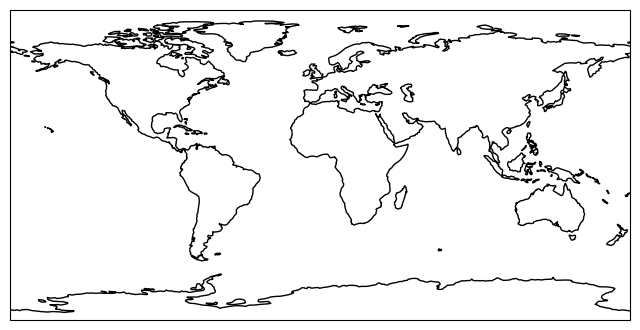

In [41]:
# Set up figure in matplotlib
fig = plt.figure(figsize=(8, 10))

# Set Plate Carree map projection using cartopy
ax = plt.axes(projection=ccrs.PlateCarree())

# Add coastlines
ax.coastlines()

# Show plot
plt.show()

In [42]:
# Define constants for Intelsat-40e geostationary orbit & Earth reference system
satellite_height = 35786023.0  # height of satellite in meters
central_longitude = -91.0  # longitude of satellite in degrees
semi_major_axis = 6378137.0  # GRS80 semi-major axis of earth in meters
semi_minor_axis = 6356752.31414  # GRS80 semi-minor axis of earth in meters
inverse_flattening = 298.257222096  # Reciprocal of GRS80 flattening factor

# Define geostationary map projection using cartopy
globe = ccrs.Globe(semimajor_axis=semi_major_axis, semiminor_axis=semi_minor_axis,
                   inverse_flattening=inverse_flattening)
geo_projection = ccrs.Geostationary(central_longitude=central_longitude,
                                    satellite_height=satellite_height, globe=globe)

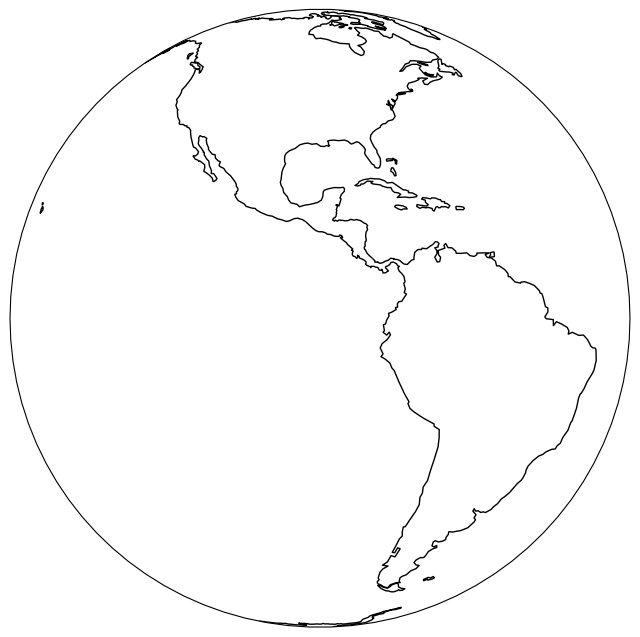

In [43]:
# Set up figure in matplotlib
fig = plt.figure(figsize=(8, 10))

# Set geostationary map projection using cartopy
ax = plt.axes(projection=geo_projection)

# Add coastlines
ax.coastlines()

# Show plot
plt.show()

/usr/local/lib/python3.10/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_physical/ne_50m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


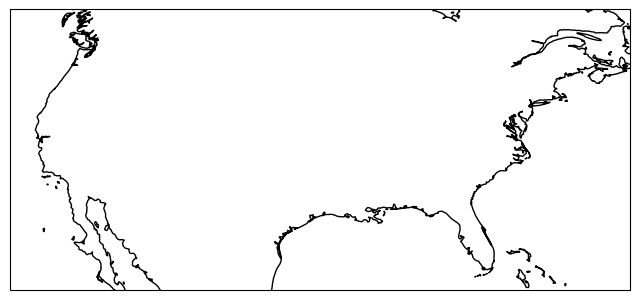

In [44]:
# Set up figure in matplotlib
fig = plt.figure(figsize=(8, 10))

# Set geostationary map projection using cartopy
ax = plt.axes(projection=geo_projection)

# Set geographic domain of map: [W_lon, E_lon, S_lat, N_lat]
# °E longitude > 0 > °W longitude, °N latitude > 0 > °S latitude
ax.set_extent([-120, -69, 24, 53], crs=ccrs.PlateCarree())

# Add coastlines
ax.coastlines()

# Show plot
plt.show()

/usr/local/lib/python3.10/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_physical/ne_50m_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/usr/local/lib/python3.10/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_physical/ne_50m_ocean.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/usr/local/lib/python3.10/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_cultural/ne_50m_admin_0_boundary_lines_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/usr/local/lib/python3.10/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_physical/ne_50m_lakes.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/usr/local/lib/python3.10/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downlo

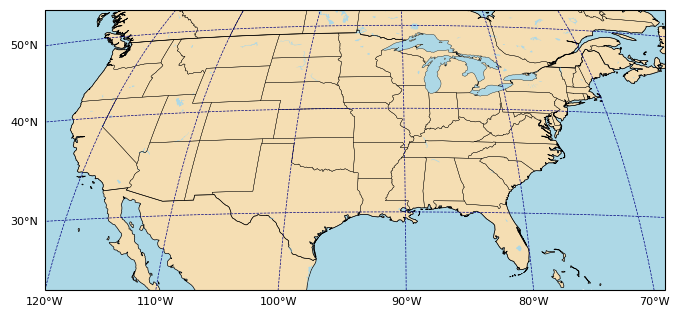

In [49]:
# Set up figure in matplotlib
fig = plt.figure(figsize=(8, 10))

# Set geostationary map projection using cartopy
ax = plt.axes(projection=geo_projection)

# Set geographic domain of map: [W_lon, E_lon, S_lat, N_lat]
# °E longitude > 0 > °W longitude, °N latitude > 0 > °S latitude
ax.set_extent([-120, -69, 24, 53], crs=ccrs.PlateCarree())

# Format lat/lon gridlines using cartopy
lon_ticks = [-120, -110, -100, -90, -80, -70]
lat_ticks = [30, 40, 50]
gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='navy', ls='--')
gl.xlocator = ticker.FixedLocator(lon_ticks)
gl.ylocator = ticker.FixedLocator(lat_ticks)
gl.right_labels = None
gl.top_labels = None
gl.xlabel_style = {'size': 8}
gl.ylabel_style = {'size': 8}

# Add coastlines & borders, shade land & water polygons
ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
ax.add_feature(cfeature.BORDERS, linewidth=0.5)
ax.add_feature(cfeature.LAKES, facecolor='lightblue')
ax.add_feature(cfeature.STATES, linewidth=0.25)
ax.add_feature(cfeature.LAND, facecolor='wheat')
ax.add_feature(cfeature.OCEAN, facecolor='lightblue')



In [50]:
# plot of whole US
# Collect all of the TEMPO NO2 .nc files in "data_files" directory
file_list = sorted(data_path.glob('TEMPO_NO2*.nc'))
print(file_list[0].name)

# Use the first NO2 granule as an example
file_date = file_list[0].name.split('_')[4][:8]
title_date = datetime.datetime.strptime(file_date, '%Y%m%d').date().strftime('%d %b %Y')
file_time = file_list[0].name.split('_')[4][9:13]
plot_title = 'TEMPO Tropospheric Column NO$_{2}$  ' + title_date + '  ' + file_time + ' UTC'
print(plot_title)

TEMPO_NO2_L2_V01_20230822T183247Z_S011G01.nc
TEMPO Tropospheric Column NO$_{2}$  22 Aug 2023  1832 UTC


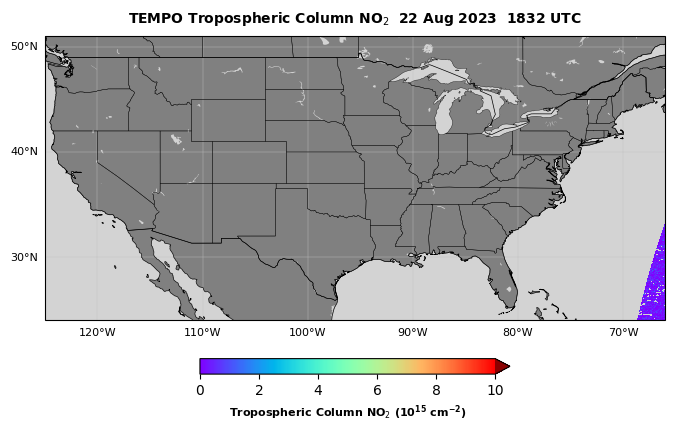

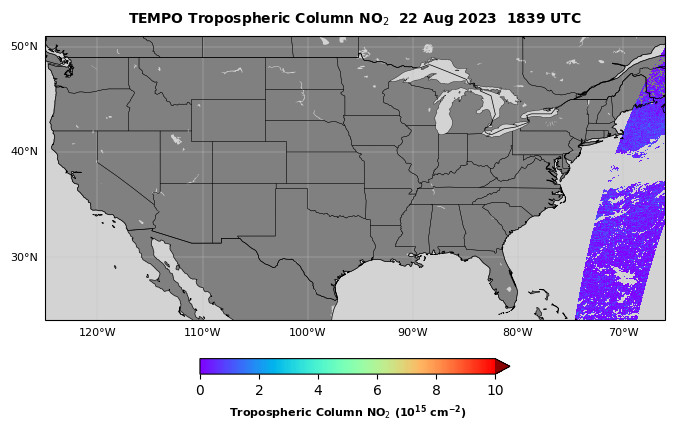

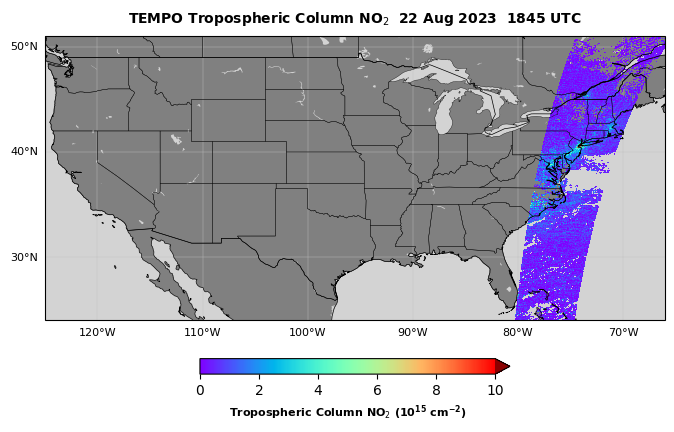

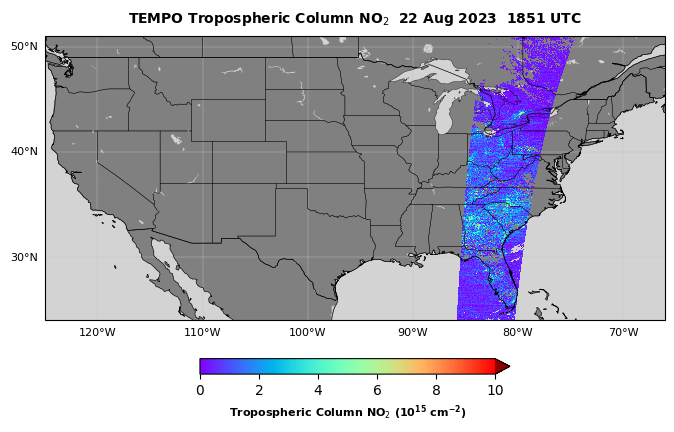

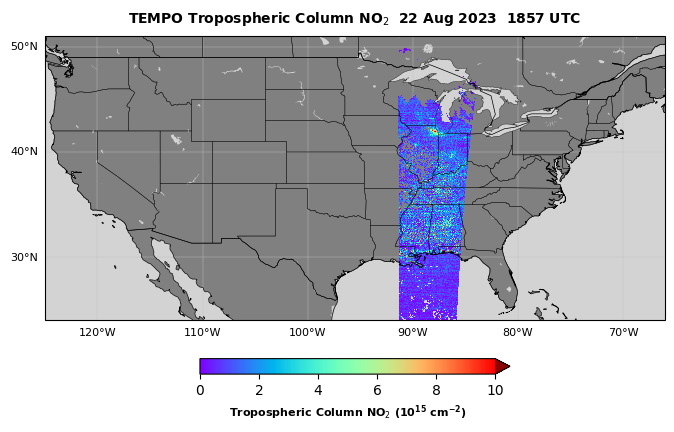

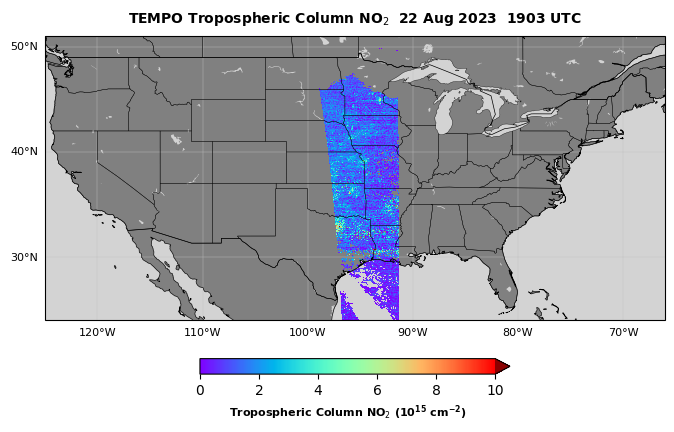

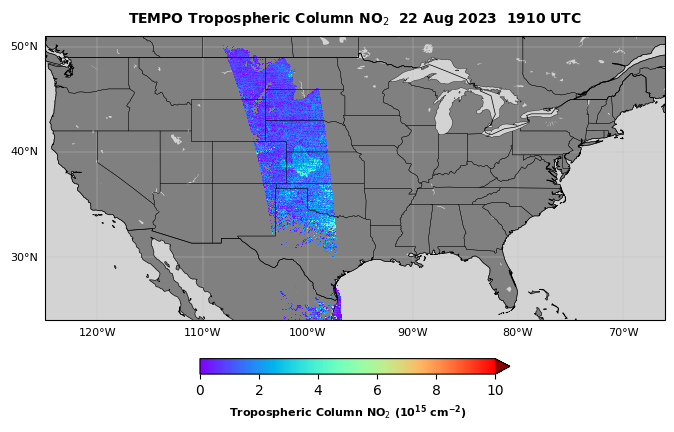

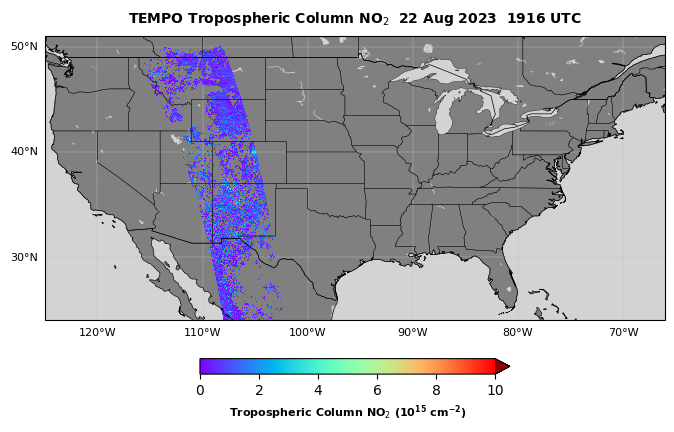

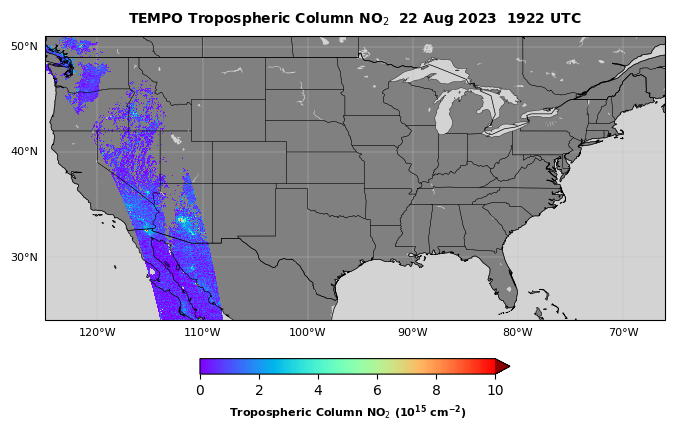

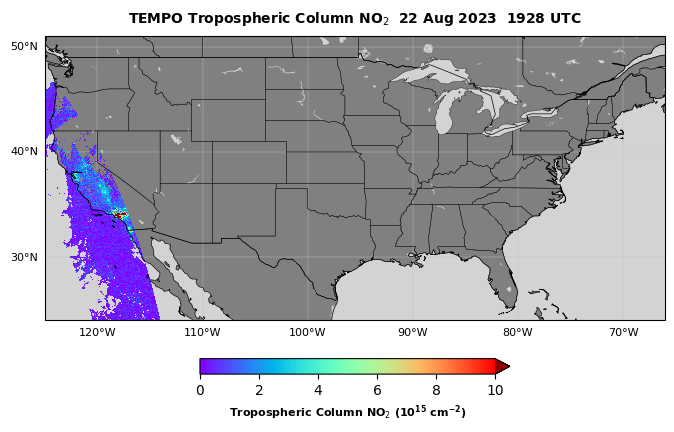

In [51]:
# plot of a section of the US
# Process & plot tropospheric NO2 from a full TEMPO scan (10 data files)

# Collect all of the TEMPO NO2 .nc files in "data_files" directory
file_list = sorted(data_path.glob('TEMPO_NO2*.nc'))

# Loop through files, plotting data from each file on a map
for file in file_list:

  # Open three "groups" in data file simultaneously
  # Automatically closes data file when done
  with (
      xr.open_dataset(file, group='product', engine='netcdf4') as ds_product,
      xr.open_dataset(file, group='geolocation', engine='netcdf4') as ds_geolocation,
      xr.open_dataset(file, group='support_data', engine='netcdf4') as ds_support_data):

      # Convert "main_data_quality_flag" DataArray to correct data type
      main_data_quality_flag = ds_product.main_data_quality_flag.astype('int16')

      # Read in & process tropospheric NO2 using quality/data flags
      # Use backslashes to break long lines of code (for clarity)
      no2 = ds_product.vertical_column_troposphere.where((main_data_quality_flag == 0) & \
                                                          (ds_geolocation.solar_zenith_angle < 70.0) & \
                                                          (ds_support_data.eff_cloud_fraction < 0.3))

      # Scale NO2 by factor of 1x10E15 (for plotting)
      no2 = no2*1.0E-15

      # Read in latitude and longitude
      # Check granule number & process latitude/longitude arrays if necessary
      granule_number = file.name.split('_')[5][5:7]
      if granule_number == '01' or granule_number == '09' or granule_number == '10':
        # Replace masked/NaN pixels with -999.99 fill value
        latitude = ds_geolocation.latitude.fillna(-999.99)
        longitude = ds_geolocation.longitude.fillna(-999.99)
      else:
        latitude = ds_geolocation.latitude
        longitude = ds_geolocation.longitude

      # Set up figure in matplotlib
      fig = plt.figure(figsize=(8, 10))

      # Set map projection using cartopy
      # Use Plate Carree projection
      ax = plt.axes(projection=ccrs.PlateCarree())

      # Set geographic domain of map: [W_lon, E_lon, S_lat, N_lat]
      # °E longitude > 0 > °W longitude, °N latitude > 0 > °S latitude
      ax.set_extent([-125, -66, 24, 51], crs=ccrs.PlateCarree())

      # Format lat/lon gridlines using cartopy
      lon_ticks = [-120, -110, -100, -90, -80, -70]
      lat_ticks = [30, 40, 50]
      gl = ax.gridlines(draw_labels=True, linewidth=0.3, color='silver', zorder=2.5)
      gl.xlocator = ticker.FixedLocator(lon_ticks)
      gl.ylocator = ticker.FixedLocator(lat_ticks)
      gl.right_labels = None
      gl.top_labels = None
      gl.xlabel_style = {'size': 8}
      gl.ylabel_style = {'size': 8}

      # Add coastlines & borders, shade land & water polygons
      # "zorder" argument sets order for plotting layers (larger zorder plots over smaller zorder)
      ax.add_feature(cfeature.COASTLINE, linewidth=0.5, zorder=3)
      ax.add_feature(cfeature.BORDERS, linewidth=0.5, zorder=3)
      ax.add_feature(cfeature.LAKES, facecolor='lightgrey')
      ax.add_feature(cfeature.STATES, linewidth=0.25, zorder=3)
      ax.add_feature(cfeature.LAND, facecolor='grey')
      ax.add_feature(cfeature.OCEAN, facecolor='lightgrey')

      # Format & add plot title
      # Pull information from file name & reformat
      file_date = file.name.split('_')[4][:8]
      title_date = datetime.datetime.strptime(file_date, '%Y%m%d').date().strftime('%d %b %Y')
      file_time = file.name.split('_')[4][9:13]
      plot_title = 'TEMPO Tropospheric Column NO$_{2}$  ' + title_date + '  ' + file_time + ' UTC'
      plt.title(plot_title, pad=10, size=10, weight='bold')

      # Set colormap with unique color for data > vmax
      cmap = plt.get_cmap('rainbow').with_extremes(over='darkred')

      # Plot tropospheric NO2 data
      # "transform=ccrs.PlateCarree()" argument tells cartopy the data are in geographic coordinates (lat/lon)
      # "zorder=2" argument plots data under coastlines/borders & over land/ocean/lakes polygons
      plot = ax.pcolormesh(longitude, latitude, no2, cmap=cmap, vmin=0, vmax=10,
                           transform=ccrs.PlateCarree(), zorder=2)

      # Add colorbar
      cb = fig.colorbar(plot, orientation='horizontal', fraction=0.2, pad=0.05,
                        shrink=0.5, ticks=[0, 2, 4, 6, 8, 10], extend='max')
      cb.set_label(label='Tropospheric Column NO$_{2}$ (10$\mathregular{^{15}}$ cm$\mathregular{^{-2}}$)',
                   size=8, weight='bold')

      # Show plot
      plt.show()

      # Save image file
      save_name = 'tempo_tropospheric_no2_' + file_date + '_' + file_time
      fig.savefig(maps_path / save_name, dpi=300, bbox_inches='tight')

      # Close plot
      plt.close()

# Integrating plots with time and other data

In [55]:
# plot over time
maps_list = sorted(maps_path.glob('*no2*.png'))

# Open map files in a list (using list comprehension)
frames = [Image.open(map) for map in maps_list]

# Save animation
pil_duration = 1000  # Time in ms between frames (e.g., 1000 ms = 1 second between frames)
pil_loop = 0  # No. times animation repeats (e.g., 0: loops continuously; 2: runs 3 times then stops)
animation_name = 'tempo_tropospheric_no2_20230822_scan011'

frames[0].save((maps_path / animation_name).as_posix() + '.gif', format='GIF',
               append_images=frames[1:], save_all=True, duration=pil_duration,
               loop=pil_loop)

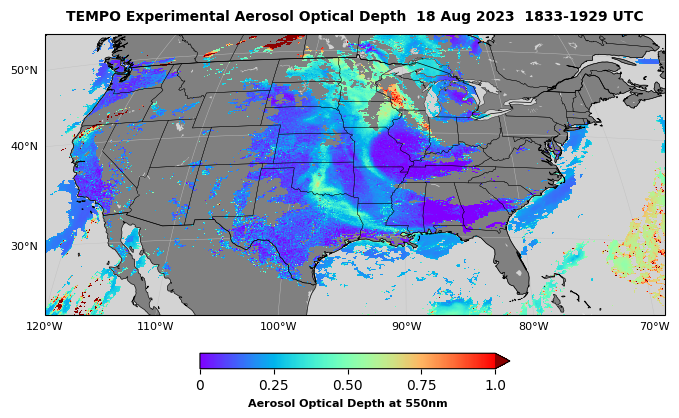

In [56]:
# Plot experimental AOD from a full TEMPO scan (10 data files) on a single map

# Collect all of the TEMPO AOD .nc files in "data_files" directory
file_list = sorted(data_path.glob('tempo_aod*.nc'))

# Set up figure in matplotlib
fig = plt.figure(figsize=(8, 10))

# Set map projection using cartopy
# Use geostationary projection defined previously
ax = plt.axes(projection=geo_projection)

# Set geographic domain of map: [W_lon, E_lon, S_lat, N_lat]
# °E longitude > 0 > °W longitude, °N latitude > 0 > °S latitude
ax.set_extent([-120, -69, 24, 53], crs=ccrs.PlateCarree())

# Format lat/lon gridlines using cartopy
lon_ticks = [-120, -110, -100, -90, -80, -70]
lat_ticks = [30, 40, 50]
gl = ax.gridlines(draw_labels=True, linewidth=0.3, color='silver', zorder=2.5)
gl.xlocator = ticker.FixedLocator(lon_ticks)
gl.ylocator = ticker.FixedLocator(lat_ticks)
gl.right_labels = None
gl.top_labels = None
gl.xlabel_style = {'size': 8}
gl.ylabel_style = {'size': 8}

# Add coastlines & borders, shade land & water polygons
# "zorder" argument sets order for plotting layers (larger zorder plots over smaller zorder)
ax.add_feature(cfeature.COASTLINE, linewidth=0.5, zorder=3)
ax.add_feature(cfeature.BORDERS, linewidth=0.5, zorder=3)
ax.add_feature(cfeature.LAKES, facecolor='lightgrey')
ax.add_feature(cfeature.STATES, linewidth=0.25, zorder=3)
ax.add_feature(cfeature.LAND, facecolor='grey')
ax.add_feature(cfeature.OCEAN, facecolor='lightgrey')

# Set colormap with unique color for data > vmax
cmap = plt.get_cmap('rainbow').with_extremes(over='darkred')

# Loop through files, plotting data from each file on the map
for file in file_list:

  # Open data file
  # Automatically closes data file when done
  with xr.open_dataset(file, engine='netcdf4') as ds:

      # Read in latitude and longitude
      # Check granule number & process latitute/longitude arrays if necessary
      granule_number = file.name.split('_')[4][5:7]
      if granule_number == '01' or granule_number == '09' or granule_number == '10':
        # Replace masked/NaN pixels with -999.99 fill value
        latitude = ds.lat.fillna(-999.99)
        longitude = ds.lon.fillna(-999.99)
      else:
        latitude = ds.lat
        longitude = ds.lon

      # Plot experimental AOD data
      # "transform=ccrs.PlateCarree()" argument tells cartopy the data are in geographic coordinates (lat/lon)
      # "zorder=2" argument plots data under coastlines/borders & over land/ocean/lakes polygons
      plot = ax.pcolormesh(longitude, latitude, ds.aod, cmap=cmap, vmin=0, vmax=1,
                           transform=ccrs.PlateCarree(), zorder=2)

# Add colorbar
cb = fig.colorbar(plot, orientation='horizontal', fraction=0.2, pad=0.05,
                  shrink=0.5, ticks=[0, 0.25, 0.5, 0.75, 1], extend='max')
cb.set_label(label='Aerosol Optical Depth at 550nm', size=8, weight='bold')
cb.ax.set_xticklabels(['0', '0.25', '0.50', '0.75', '1.0'])

# Format & add plot title
# Pull information from file names & reformat
file_date = file_list[0].name.split('_')[3][:8]
title_date = datetime.datetime.strptime(file_date, '%Y%m%d').date().strftime('%d %b %Y')
first_file_time = file_list[0].name.split('_')[3][9:13]
last_file_time = file_list[-1].name.split('_')[3][9:13]
plot_title = 'TEMPO Experimental Aerosol Optical Depth  ' + title_date + '  ' + first_file_time + '-' + last_file_time + ' UTC'
plt.title(plot_title, pad=10, size=10, weight='bold')

# Show plot
plt.show()
save_name = 'tempo_experimental_aod_' + file_date + '_' + first_file_time + '_' + last_file_time
fig.savefig(maps_path / save_name, dpi=300, bbox_inches='tight')
plt.close()

In [ ]:
# choosing a location and getting a line plot over time


# Exercises

The goal of this exercise is to use what you learned above to successfully plot a region of your choosing with both NO2 and Wind Vector data for an exploratory analysis of that spatiotemporal occurrence.

# Limitations of the tool as of May 2024:

1.
2.
3.
4.
5.
6.
7.
8.
9.
10.



# Another Approach! PyRSIG
Now, Let's move on to using PyRSIG, the EPA's data access tool. This tool is better used for applications when intereacting with the EPA native data, such as ground monitors.

PyRSIG is an alternative to RSIG3D, a Python interface that leverages RSIG's web services to import data directly into pandas dataframes and xarray datasets. This makes it easy to do advanced analysis and visualization in a “Pythonic” way.

Let's look at the EPA's definition of what makes PyRSIG special:

"
One access point to many data sources. The RSIG provides a single Web site that serves as a selective access point to many kinds of data.
- Streams only the needed data. The RSIG accesses large numbers of files from diverse sources and streams the user-selected subset of data back to the user's desktop. Streaming works in the same way as streaming audio works on the Web: the data goes directly to the client computer's memory and is discarded unless the user saves it to a file.
- Aggregates separate data files into a single stream. RSIG aggregates the multiple files of a given data type into a single stream, reducing the download burden and simplifying data analysis.
- Built-in visualization. RSIG can immediately integrate multiple selected datasets into a single MPEG animation. For example, EPA AIRNow data can be layered over NASA's MODIS satellite data, or a user can compare CMAQ predicted outputs and actual ground sensor data. The user can also save the animation or individual images to their computer.
- Saves data to standard formats. RSIG integrates incoming proprietary dataset formats into standard formats the user can save on their computer
    
- A user can save the data or visualization--or both--to their local computer in such standard formats as portable binary, ASCII, NetCDF IOAPI and COARDS, GeoTIFF, MPEG and KMZ. The user can then export the selected datasets from RSIG into other applications--such as GIS tools--for further analysis
-  Fast. RSIG accomplishes all of this far faster than a lone user could with currently available means. For example, RSIG can capture a week of MODIS AOD data in a few minutes, compared to two months using conventional web-form ordering/ftp approaches.
"

## Why bother?

PyRSIG allows us to do quick and easy analysis using TEMPO data and EPA data. One might make a map, or perhaps a time series for fast comparison at location level data.

**Knowledge check:** What is the difference between the storage of EPA and NASA data, and which tool is best for each, respectively?

In [59]:
# This ensures the directory ~/.pycno is created in the user's home directory, used for configuration files
os.makedirs(os.path.expanduser('~/.pycno'), exist_ok=True)

The cell below creates an RSIG api isntance and a bounding box (a rectangular border that fully contains an object or a set of points within a given space. In geospatial analysis and object detection in images, bounding boxes are used to specify the location and dimensions of objects. The box is defined by the coordinates of its top-left and bottom-right corners, or alternatively, by its center, width, and height. Bounding boxes are fundamental in tasks that require spatial referencing or object localization.)

In [61]:
bbox = (-112.3, 33.25, -111.85, 33.65)
rsigapi = pyrsig.RsigApi(
    bdate='2013-07-01 00', edate='2013-07-03 23:59:59', bbox=bbox
)

In [66]:
from geopy.distance import distance

def get_bounding_box(city_name, distance_miles=50):
    # Dictionary of city coordinates
    cities = {
        "San Francisco": (37.7749, -122.4194),
        "New York": (40.7128, -74.0060),
        "Chicago": (41.8781, -87.6298),
        # Add more cities as needed
    }

    if city_name not in cities:
        raise ValueError(f"Coordinates for city '{city_name}' not found")

    lat, lon = cities[city_name]

    # Calculate the bounding box
    north = distance(miles=distance_miles).destination((lat, lon), bearing=0)[0]
    south = distance(miles=distance_miles).destination((lat, lon), bearing=180)[0]
    east = distance(miles=distance_miles).destination((lat, lon), bearing=90)[1]
    west = distance(miles=distance_miles).destination((lat, lon), bearing=270)[1]

    return [west, south, east, north]


In [69]:
city_name = "San Francisco"
bounding_box = list(get_bounding_box(city_name[:]))
bounding_box

[-123.3327304136054, 37.04987484946566, -121.50606958639459, 38.49983572950003]

In [70]:
rsigapi = pyrsig.RsigApi(
    bdate='2013-07-01 00', edate='2013-07-03 23:59:59', bbox=bounding_box
)

In [71]:
[k for k in rsigapi.keys() if k.startswith('tempo.')]

['tempo.l2.cldo4.CloudRadianceFraction440',
 'tempo.l2.cldo4.CloudRadianceFraction466',
 'tempo.l2.cldo4.GLER440',
 'tempo.l2.cldo4.GLER466',
 'tempo.l2.cldo4.SCD_MainDataQualityFlags',
 'tempo.l2.cldo4.SceneLER440',
 'tempo.l2.cldo4.SceneLER466',
 'tempo.l2.cldo4.ScenePressure',
 'tempo.l2.cldo4.cloud_fraction',
 'tempo.l2.cldo4.cloud_pressure',
 'tempo.l2.cldo4.fit_convergence_flag',
 'tempo.l2.cldo4.fit_rms_residual',
 'tempo.l2.cldo4.fitted_slant_column',
 'tempo.l2.cldo4.fitted_slant_column_uncertainty',
 'tempo.l2.cldo4.ground_pixel_quality_flag',
 'tempo.l2.cldo4.processing_quality_flag',
 'tempo.l2.cldo4.relative_azimuth_angle',
 'tempo.l2.cldo4.snow_ice_fraction',
 'tempo.l2.cldo4.solar_azimuth_angle',
 'tempo.l2.cldo4.solar_zenith_angle',
 'tempo.l2.cldo4.surface_pressure',
 'tempo.l2.cldo4.terrain_height',
 'tempo.l2.cldo4.viewing_azimuth_angle',
 'tempo.l2.cldo4.viewing_zenith_angle',
 'tempo.l2.hcho.albedo',
 'tempo.l2.hcho.amf',
 'tempo.l2.hcho.amf_cloud_fraction',
 'temp

In [72]:
rsigapi.describe('tempo2.proxy_l2.no2.vertical_column_troposphere')

,name,label,description,beginPosition,timeResolution,prefix
0,proxy_l2.no2.vertical_column_troposphere,proxy_l2.no2.vertical_column_troposphere(molec...,Vertical column amount of NO2 in the tropoosph...,2023-10-17T00:00:00Z,PT1Y,proxy_l2


In [73]:
# Get AQS NO2 with dates parsed and units removed from column names
aqsno2df = rsigapi.to_dataframe('aqs.no2', parse_dates=True, unit_keys=False)

# Get TropOMI NO2
tempono2df = rsigapi.to_dataframe(
    'tempo2.proxy_l2.no2.vertical_column_troposphere',
    unit_keys=False, parse_dates=True
)
tempono2df

,Timestamp,LONGITUDE,LATITUDE,no2_vertical_column_troposphere,Longitude_SW,Longitude_SE,Longitude_NW,Longitude_NE,Latitude_SW,Latitude_SE,Latitude_NW,Latitude_NE,time
0,2013-07-01T00:53:00-0000,-123.1462,37.05223,1.156706e+15,-123.1070,-123.1744,-123.1179,-123.1854,37.04018,37.04447,37.06000,37.06430,2013-07-01 00:53:00+00:00
1,2013-07-01T00:53:00-0000,-123.2136,37.05653,8.876406e+14,-123.1744,-123.2419,-123.1854,-123.2529,37.04447,37.04877,37.06430,37.06861,2013-07-01 00:53:00+00:00
2,2013-07-01T00:53:00-0000,-123.2812,37.06085,6.344013e+14,-123.2419,-123.3095,-123.2529,-123.3205,37.04877,37.05310,37.06861,37.07293,2013-07-01 00:53:00+00:00
3,2013-07-01T00:53:00-0000,-122.8208,37.05071,6.611685e+14,-122.7820,-122.8490,-122.7927,-122.8598,37.03870,37.04293,37.05850,37.06274,2013-07-01 00:53:00+00:00
4,2013-07-01T00:53:00-0000,-122.8879,37.05496,1.145348e+15,-122.8490,-122.9161,-122.8598,-122.9269,37.04293,37.04718,37.06274,37.06700,2013-07-01 00:53:00+00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
77187,2013-07-03T23:53:00-0000,-121.5248,38.48074,1.655483e+15,-121.4858,-121.5529,-121.4968,-121.5639,38.46845,38.47269,38.48880,38.49304,2013-07-03 23:53:00+00:00
77188,2013-07-03T23:53:00-0000,-121.5919,38.48499,2.444435e+15,-121.5529,-121.6200,-121.5639,-121.6311,38.47269,38.47695,38.49304,38.49731,2013-07-03 23:53:00+00:00
77189,2013-07-03T23:53:00-0000,-121.6591,38.48926,2.481209e+15,-121.6200,-121.6872,-121.6311,-121.6983,38.47695,38.48122,38.49731,38.50158,2013-07-03 23:53:00+00:00
77190,2013-07-03T23:53:00-0000,-121.7264,38.49353,1.035551e+15,-121.6872,-121.7546,-121.6983,-121.7657,38.48122,38.48550,38.50158,38.50587,2013-07-03 23:53:00+00:00


In [ ]:
# Create spatial means for TropOMI and AQS
tempono2s = (
    tempono2df.groupby('time').median(numeric_only=True)['no2_vertical_column_troposphere']
)
aqsno2s = aqsno2df.groupby(['time']).median(numeric_only=True)['no2']

# Subset AQS to overpass times
oaqsno2s = aqsno2s.loc[aqsno2s.index.isin(tempono2s.index.floor('1h'))] # just overpass t

# Create axes with shared x
fig, ax = plt.subplots(figsize=(12, 4),
                       gridspec_kw=dict(bottom=0.25, left=0.05, right=0.95))
ax.tick_params(axis='x', labelrotation = 90)
tax = ax.twinx()

# Add AQS with markers at overpasses
ax.plot(aqsno2s.index.values, aqsno2s.values, color='k')
ax.scatter(oaqsno2s.index.values, oaqsno2s.values, marker='o', color='b')

# Add TropOMI NO2
tax.plot(tempono2s.index.values, tempono2s.values, marker='s', color='r')

# Configure axes
ax.set(ylabel='AQS NO2 ppb')
tax.set(ylim=(0, 1.7e16), ylabel='TEMPO-PROXY NO2 molec/cm$^2$')

plt.show()
# Or save out figure